<a href="https://colab.research.google.com/github/rogerqiu7/foodvision-deep-learning-classifier/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FoodVision - Deep Learning Food Classifier 🍕🥩🍣

- Built a CNN-based image classifier using PyTorch and transfer learning
  (ResNet50) achieving 98% accuracy on pizza/steak/sushi classification
- Implemented MLOps pipeline with MLflow for experiment tracking and
  model versioning across multiple architectures
- Deployed interactive web demo using Gradio with real-time inference
- Tech Stack: PyTorch, torchvision, MLflow, Gradio, Python

## 1. Setup and Imports

In [2]:
# torch: Core deep learning framework
# torchvision: CV datasets, models, transforms
# mlflow: Experiment tracking
# gradio: Web UI for model demos
# tqdm: Progress bars
# torchinfo: Model architecture summaries
!pip install -q torch torchvision mlflow gradio tqdm torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00


In [3]:
# Import necessary libraries

# --- Standard Library ---
import os                      # File system operations (paths, directories)
from pathlib import Path       # Modern, object-oriented path handling (preferred over os.path)
from typing import Dict, List, Tuple  # Type hints for better code documentation and IDE support
from datetime import datetime  # Timestamping experiments and model checkpoints
import zipfile                 # Extract compressed datasets
import requests                # Download datasets/files from URLs

# --- Core PyTorch ---
import torch                   # Main PyTorch library for tensor operations
import torch.nn as nn          # Neural network modules (layers, loss functions, etc.)

# --- Computer Vision ---
import torchvision             # CV datasets, pretrained models, and utilities
from torchvision import transforms, datasets
    # transforms: Data augmentation & preprocessing (resize, normalize, flip, etc.)
    # datasets: Built-in CV datasets (CIFAR, ImageNet, etc.)

# --- Data Loading ---
from torch.utils.data import DataLoader  # Efficient batching, shuffling, and parallel data loading

# --- Training Utilities ---
from tqdm.auto import tqdm     # Progress bars for loops (.auto detects notebook vs terminal)

# --- Experiment Tracking (MLOps) ---
import mlflow                  # Experiment management framework
import mlflow.pytorch          # PyTorch-specific MLflow integrations (model logging)

# --- Visualization ---
import matplotlib.pyplot as plt  # Plotting training curves, sample predictions, etc.

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6


## 2. Download Data

In [4]:
def set_seeds(seed: int = 42):
    """
    Set random seeds across all libraries for reproducible results.

    Why this matters:
    - Neural network weight initialization is random
    - Data shuffling in DataLoader is random
    - Dropout and augmentation operations use randomness

    Without fixed seeds, you'll get different results every run, making it
    impossible to debug or compare experiments fairly.
    """
    torch.manual_seed(seed)              # CPU operations
    torch.cuda.manual_seed(seed)         # Current GPU operations
    torch.cuda.manual_seed_all(seed)     # All GPUs (if using multi-GPU) - YOU'RE MISSING THIS!

    # Makes PyTorch use deterministic algorithms (may be slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def download_data(source: str, destination: str, remove_source: bool = True) -> Path:
    """
    Download, extract, and cache a dataset from a remote URL.

    If data already exists locally,
    it skips re-downloading (saves time and bandwidth on repeated runs).

    Args:
        source: URL to the zipped dataset
        destination: Folder name to extract into (e.g., "pizza_steak_sushi")
        remove_source: If True, delete the .zip file after extraction to save disk space

    Returns:
        Path object pointing to the extracted dataset directory

    Example:
        >>> data_path = download_data(
        ...     source="https://github.com/user/repo/data.zip",
        ...     destination="my_dataset"
        ... )
        >>> print(data_path)  # data/my_dataset

    Directory Structure Created:
        data/
        └── my_dataset/        <- This is what gets returned
            ├── train/
            │   ├── class1/
            │   └── class2/
            └── test/
                ├── class1/
                └── class2/
    """
    # Define base data directory and target extraction path
    data_path = Path("data/")
    image_path = data_path / destination

    # --- CACHING LOGIC: Skip download if data exists ---
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
        return image_path  # Early return to avoid redundant work

    # --- DOWNLOAD PHASE ---
    print(f"[INFO] Did not find {image_path}, creating directory...")
    image_path.mkdir(parents=True, exist_ok=True)  # Create nested dirs if needed

    # Extract filename from URL (e.g., "data.zip" from "https://site.com/data.zip")
    target_file = Path(source).name

    # Stream download to disk (memory-efficient for large files)
    with open(data_path / target_file, "wb") as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)

    # --- EXTRACTION PHASE ---
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Unzipping {target_file} to {image_path}...")
        zip_ref.extractall(image_path)

    # --- CLEANUP PHASE ---
    if remove_source:
        os.remove(data_path / target_file)
        print(f"[INFO] Removed zip file to save space")

    return image_path

In [5]:
# Download food classification dataset (pizza/steak/sushi)
# 20% subset for faster prototyping
data_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent"
)

train_dir = data_path / "train"
test_dir = data_path / "test"

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

[INFO] Did not find data/pizza_steak_sushi_20_percent, creating directory...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip to data/pizza_steak_sushi_20_percent...
[INFO] Removed zip file to save space
Train directory: data/pizza_steak_sushi_20_percent/train
Test directory: data/pizza_steak_sushi_20_percent/test


In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(train_dir), walk_through_dir(test_dir)

There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


(None, None)

## 3. Check the Data

Random image path: data/pizza_steak_sushi_20_percent/train/sushi/1674187.jpg
Image class: sushi
Image height: 512
Image width: 512


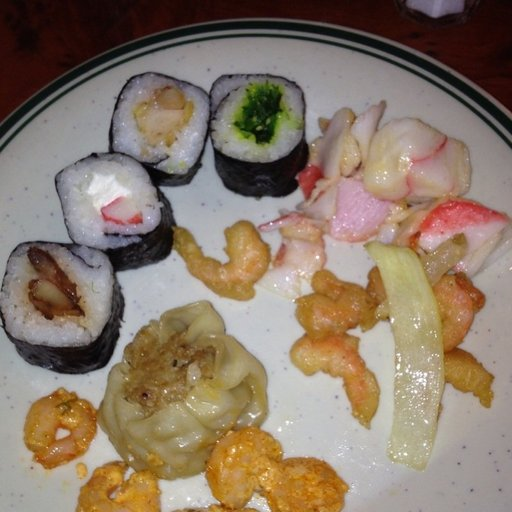

In [10]:
import random
from PIL import Image

# Set seed for reproducible random selection
random.seed(42)

# Get all training image paths using glob pattern
# Pattern: train/pizza/*.jpg, train/steak/*.jpg, train/sushi/*.jpg
image_path_list = list(train_dir.glob("*/*.jpg"))

# Randomly select one image for inspection
random_image_path = random.choice(image_path_list)

# Extract class label from directory structure
# Example: data/train/pizza/image001.jpg -> class = "pizza"
image_class = random_image_path.parent.stem  # .stem gets folder name without path

# Load image using PIL (Pillow library)
img = Image.open(random_image_path)

# Display image properties
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img  # Jupyter displays the image automatically

## 4. Convert to datasets

In [11]:
from torchvision import datasets, transforms

def create_datasets(train_dir: str,
                    test_dir: str,
                    train_transform: transforms.Compose,
                    test_transform: transforms.Compose):
    """
    Creates train and test datasets with custom transforms.

    Uses ImageFolder which:
    - Automatically labels images based on subdirectory names
    - Returns (image_tensor, label_index) pairs
    - Infers class_to_idx mapping (e.g., {'pizza': 0, 'steak': 1, 'sushi': 2})

    Args:
        train_dir: Path to training images (with class subdirectories)
        test_dir: Path to test images (with class subdirectories)
        train_transform: Augmentation pipeline for training (RandomCrop, flips, etc.)
        test_transform: Preprocessing only for test (resize, normalize)

    Returns:
        Tuple of (train_dataset, test_dataset, class_names)
    """
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Extract class names from folder structure (alphabetically sorted)
    class_names = train_data.classes

    return train_data, test_data, class_names

In [12]:
# create a demo transform just to visualize

# Training pipeline: Aggressive augmentation for better generalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard ImageNet input size (most pretrained models expect this)
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # AutoAugment policy: random crops, rotations, color shifts, etc.
    transforms.ToTensor()  # Convert PIL Image -> Tensor, scale pixels [0,255] -> [0,1]
])

# Test pipeline: No augmentation, only standardization
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Match training size
    transforms.ToTensor()  # Convert to tensor
])

# Create datasets using the factory function
train_data, test_data, class_names = create_datasets(
    train_dir="data/pizza_steak_sushi_20_percent/train",
    test_dir="data/pizza_steak_sushi_20_percent/test",
    train_transform=train_transforms,
    test_transform=test_transforms
)

In [15]:
# inspect training data
train_data[0]

(tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1176, 0.1137],
          [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1176],
          [0.1216, 0.1255, 0.1216,  ..., 0.1098, 0.1176, 0.1137],
          ...,
          [0.1804, 0.1725, 0.1725,  ..., 0.0863, 0.0902, 0.0941],
          [0.1686, 0.1686, 0.1647,  ..., 0.0902, 0.0902, 0.0902],
          [0.1529, 0.1529, 0.1490,  ..., 0.0824, 0.0863, 0.0863]],
 
         [[0.0549, 0.0549, 0.0549,  ..., 0.0824, 0.0745, 0.0706],
          [0.0588, 0.0627, 0.0627,  ..., 0.0706, 0.0706, 0.0745],
          [0.0627, 0.0667, 0.0627,  ..., 0.0667, 0.0784, 0.0706],
          ...,
          [0.2314, 0.2314, 0.2353,  ..., 0.1020, 0.1059, 0.1098],
          [0.2314, 0.2314, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
          [0.2235, 0.2235, 0.2196,  ..., 0.0980, 0.1020, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.1059, 0.0980, 0.0941],
          [0.0196, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
          [0.0196, 0.0235, 0.0235,  ...,

In [16]:
# train data contains tuples: (tensor([[R channel], [G channel], [B channel]]), 1) <- label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1098, 0.1098],
         [0.1098, 0.1098, 0.1098,  ..., 0.1098, 0.1098, 0.1098],
         [0.1098, 0.1255, 0.1098,  ..., 0.1098, 0.1098, 0.1098],
         ...,
         [0.1725, 0.1725, 0.1725,  ..., 0.0784, 0.0784, 0.0941],
         [0.1569, 0.1569, 0.1569,  ..., 0.0784, 0.0784, 0.0784],
         [0.1412, 0.1412, 0.1412,  ..., 0.0784, 0.0784, 0.0784]],

        [[0.0471, 0.0471, 0.0471,  ..., 0.0784, 0.0627, 0.0627],
         [0.0471, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0784, 0.0627],
         ...,
         [0.2196, 0.2196, 0.2353,  ..., 0.0941, 0.0941, 0.1098],
         [0.2196, 0.2196, 0.2196,  ..., 0.0941, 0.0941, 0.0941],
         [0.2196, 0.2196, 0.2196,  ..., 0.0941, 0.0941, 0.0941]],

        [[0.0157, 0.0157, 0.0157,  ..., 0.0941, 0.0941, 0.0941],
         [0.0157, 0.0157, 0.0157,  ..., 0.0941, 0.0941, 0.0941],
         [0.0157, 0.0157, 0.0157,  ..., 0.07

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


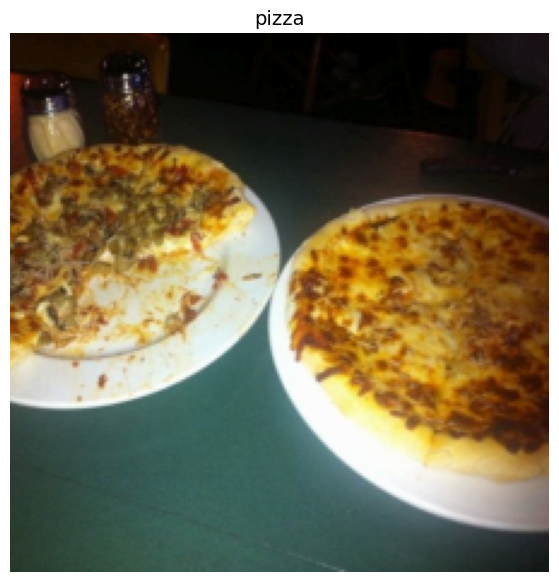

In [17]:
# Rearrange tensor dimensions for matplotlib compatibility
# PyTorch uses [C, H, W] but matplotlib expects [H, W, C]
img_permute = img.permute(1, 2, 0)

# Show dimension transformation
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Visualize the image with its class label as title
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)  # Expects [224, 224, 3] format
plt.axis("off")  # Hide axis ticks
plt.title(class_names[label], fontsize=14);  # Display class name (e.g., "pizza")

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

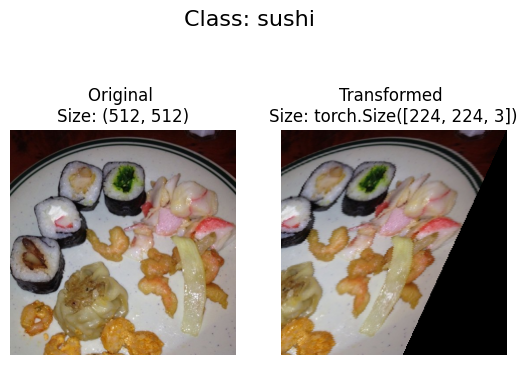

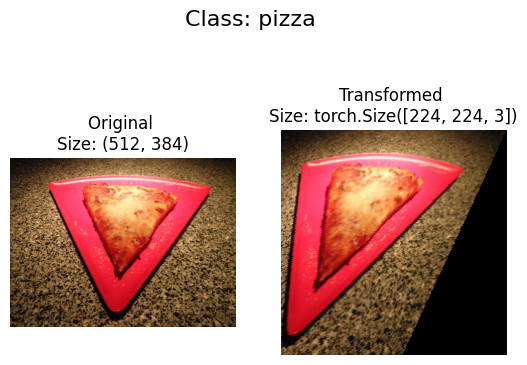

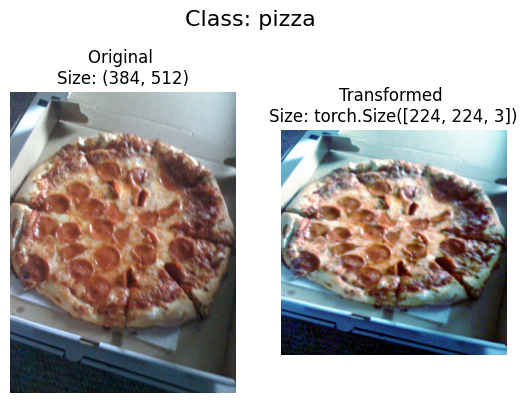

In [19]:
image_paths = list(Path("data/pizza_steak_sushi_20_percent/train").rglob("*.jpg"))

# show images before and after transformation
plot_transformed_images(
    image_paths=image_paths,
    transform=train_transforms,
    n=3
)

## 4. DataLoader Creation

In [32]:
from torch.utils.data import DataLoader

def create_dataloaders(train_data, test_data, batch_size: int, num_workers: int = 2):
    """
    Wraps datasets in DataLoaders for batching and parallel loading.

    DataLoader converts:
        Single sample [3, 224, 224] → Batch [batch_size, 3, 224, 224]

    Args:
        train_data: Training dataset
        test_data: Test dataset
        batch_size: Number of samples per batch (typical: 32, 64, 128)
        num_workers: Parallel data loading threads (speeds up I/O)

    Returns:
        (train_loader, test_loader, class_names)
    """
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,  # Randomize order each epoch (prevents overfitting to sequence)
        num_workers=num_workers,  # Load data in parallel (CPU threads)
        pin_memory=True,  # Faster CPU→GPU transfer (use with CUDA)
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,  # Keep order consistent for evaluation
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader

## 5. Model Creation (Multiple Architectures)

In [21]:
def create_model(model_name: str, num_classes: int = 3, seed: int = 42):
    """
    Creates pretrained model with frozen layers + custom classifier.

    Transfer learning strategy:
    1. Load model pretrained on ImageNet (1000 classes)
    2. Freeze early layers (feature extraction remains unchanged)
    3. Replace final layer to output 3 classes (pizza/steak/sushi)
    4. Only train the new classifier head

    Args:
        model_name: "efficientnet_b2" or "resnet50"
        num_classes: Output classes (3 for this dataset)
        seed: Reproducibility for weight initialization

    Returns:
        (model, pretrained_transforms)
    """

    # Set seeds for reproducible weight initialization
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    if model_name == "efficientnet_b2":
        # Load pretrained weights from ImageNet
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
        model = torchvision.models.efficientnet_b2(weights=weights)

        # Number of features coming out of backbone and into the final classification layer
        in_features = model.classifier[1].in_features  # 1408 features

        # Freeze all convolutional layers (pretrained features are good enough)
        for param in model.features.parameters():
            param.requires_grad = False

        # Replace classifier head, final layer: 1408 → 3 classes
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),  # Regularization (30% neuron dropout)
            nn.Linear(in_features, num_classes),  # Final projection layer
        )

    elif model_name == "resnet50":
        weights = torchvision.models.ResNet50_Weights.DEFAULT
        model = torchvision.models.resnet50(weights=weights)

        in_features = model.fc.in_features  # 2048 features

        # Freeze first 3 residual blocks (keep low-level features frozen)
        # Only train layer4 + classifier for faster convergence
        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False
        for param in model.layer3.parameters():
            param.requires_grad = False

        # Replace classifier: 2048 → 3 classes
        model.fc = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' not supported. Choose 'efficientnet_b2' or 'resnet50'.")

    # Get official preprocessing transforms used for the pretrained model
    # Pretrained models are sensitive to preprocessing.
    # If you use different transforms than what the model was trained with, accuracy drops significantly.
    transforms_obj = weights.transforms()

    return model, transforms_obj

## 6. Training Functions

In [34]:
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    """
    Trains model for one epoch.

    Returns:
        (average_loss, average_accuracy) for the epoch
    """

    # Set model to training mode (enables dropout, batch norm updates)
    model.train()

    train_loss, train_acc = 0, 0

    # Iterate through all batches in dataset
    for X, y in dataloader:
        # Move batch to GPU
        X, y = X.to(device), y.to(device)  # X: [batch_size, 3, 224, 224], y: [batch_size]

        # Forward pass: get predictions
        y_pred = model(X)  # [batch_size, 3] - logits for 3 classes

        # Calculate loss (how wrong the predictions are)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate for averaging later

        # Backward pass: compute gradients
        optimizer.zero_grad()  # Clear old gradients from previous step
        loss.backward()        # Calculate gradients via backpropagation
        optimizer.step()       # Update weights using gradients

        # Calculate accuracy: convert logits → class predictions
        y_pred_class = torch.argmax(y_pred, dim=1)  # Get highest logit index [batch_size]
        train_acc += (y_pred_class == y).sum().item() / len(y)  # ← len(y) not len(y_pred)

    # Average metrics across all batches
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [38]:
def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluates model on test data for one epoch.

    Key differences from train_step:
    - No gradient computation (faster, less memory)
    - No weight updates (read-only evaluation)
    - Dropout/BatchNorm in eval mode

    Returns:
        (average_loss, average_accuracy) on test set
    """

    # Set model to evaluation mode (disables dropout, freezes batch norm)
    model.eval()

    test_loss, test_acc = 0, 0

    # Disable gradient tracking (saves memory + speeds up inference)
    with torch.inference_mode():
        for X, y in dataloader:
            # Move batch to GPU
            X, y = X.to(device), y.to(device)

            # Forward pass only (no backward pass)
            test_pred = model(X)  # [batch_size, 3] logits

            # Calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred.argmax(dim=1)  # Convert logits → class predictions
            test_acc += (test_pred_labels == y).sum().item() / len(y)  # ← len(y) not len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc  # ← Make sure this line exists!

In [39]:
def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    device: torch.device,
    model_name: str
) -> Dict[str, List]:
    """
    Full training pipeline with experiment tracking.

    For each epoch:
    1. Train on full training set (update weights)
    2. Evaluate on test set (measure generalization)
    3. Log metrics to MLflow (for experiment comparison)
    4. Store results for plotting

    Returns:
        Dictionary of training history for visualization
    """

    # Initialize metric storage
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Main training loop
    for epoch in tqdm(range(epochs)):
        # Train for one epoch (update model weights)
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Evaluate on test set (no weight updates)
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Store metrics for later plotting
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Log to MLflow (enables experiment comparison in UI)
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test_acc", test_acc, step=epoch)

        # Print progress
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    return results

## 7. Main Training Loop with MLflow

In [28]:
# Configure MLflow experiment (groups all training runs together)
mlflow.set_experiment("Food_Classification")

# Training hyperparameters
BATCH_SIZE = 32        # Images per batch (32 is good for T4 GPU memory)
EPOCHS = 5             # Full passes through training data (low for quick testing)
LEARNING_RATE = 0.001  # Step size for weight updates (0.001 is standard for Adam)

# Model architectures to compare
models_to_test = [
    "efficientnet_b2",  # More efficient, fewer params
    "resnet50"          # Classic architecture, widely used
]

# Track best performing model across all experiments
best_accuracy = 0
best_model_name = None
best_model_path = None
results_summary = []  # Store results for comparison table

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/11 15:20:56 INFO mlflow.tracking.fluent: Experiment with name 'Food_Classification' does not exist. Creating a new experiment.


In [40]:
from mlflow.models.signature import infer_signature

# Train and compare multiple models
for model_name in models_to_test:
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")

    # Start MLflow run (tracks all metrics/artifacts for this model)
    with mlflow.start_run(run_name=model_name):

        # ========================================
        # 1. SETUP PHASE
        # ========================================

        set_seeds(42)  # Reproducible weight initialization

        # Load pretrained model with custom classifier head
        model, transform = create_model(model_name, num_classes=3)
        model = model.to(device)  # Move to GPU

        # Create datasets from data directory using model-specific transforms
        train_data, test_data, class_names = create_datasets(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=transform,  # Official pretrained transforms
            test_transform=transform
        )

        # Wrap datasets in DataLoaders for batching
        train_dataloader, test_dataloader = create_dataloaders(
            train_data=train_data,
            test_data=test_data,
            batch_size=BATCH_SIZE
        )

        # Define loss function and optimizer
        loss_fn = nn.CrossEntropyLoss()  # Standard for multi-class classification
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # ========================================
        # 2. LOG EXPERIMENT CONFIG TO MLFLOW
        # ========================================

        params = {
            "model_name": model_name,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "optimizer": "Adam",
            "augmentation": str(transform),
            "train_size": len(train_data),
            "val_size": len(test_data),
            "num_classes": len(class_names),
            "classes": class_names,
        }
        mlflow.log_params(params)

        # ========================================
        # 3. TRAINING PHASE
        # ========================================

        results = train(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=EPOCHS,
            device=device,
            model_name=model_name
        )

        # Extract final performance
        final_test_acc = results["test_acc"][-1]

        # ========================================
        # 4. SAVE MODEL CHECKPOINT
        # ========================================

        model_save_path = f"models/{model_name}_best.pth"
        os.makedirs("models", exist_ok=True)

        # Save with metadata for easy loading later
        torch.save({
            'model_state_dict': model.state_dict(),  # Trained weights
            'model_name': model_name,
            'class_names': class_names,
            'test_acc': final_test_acc
        }, model_save_path)

        # ========================================
        # 5. LOG MODEL TO MLFLOW
        # ========================================

        # Create example input for model signature (helps with deployment)
        example_input = torch.randn(1, 3, 224, 224).to(device)
        example_output = model(example_input)

        # Convert to NumPy (MLflow requirement)
        example_input_np = example_input.cpu().numpy()
        example_output_np = example_output.detach().cpu().numpy()

        # Log model with input/output schema
        mlflow.pytorch.log_model(
            model,
            artifact_path=f"{model_name}_model",
            input_example=example_input_np,
            signature=infer_signature(example_input_np, example_output_np)
        )

        # ========================================
        # 6. TRACK BEST MODEL ACROSS RUNS
        # ========================================

        if final_test_acc > best_accuracy:
            best_accuracy = final_test_acc
            best_model_name = model_name
            best_model_path = model_save_path
            best_results = results  # Save training history for plotting

            # Save best model separately for easy access
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_name': model_name,
                'class_names': class_names,
                'test_acc': final_test_acc
            }, "models/best_model.pth")

        # ========================================
        # 7. STORE RESULTS FOR COMPARISON
        # ========================================

        results_summary.append({
            'model': model_name,
            'test_acc': final_test_acc
        })

        print(f"\nFinal test accuracy: {final_test_acc:.4f}")


Training efficientnet_b2



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9717 | train_acc: 0.5875 | test_loss: 0.7472 | test_acc: 0.9136
Epoch: 2 | train_loss: 0.6832 | train_acc: 0.8354 | test_loss: 0.5818 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.5908 | train_acc: 0.8500 | test_loss: 0.4968 | test_acc: 0.9506
Epoch: 4 | train_loss: 0.4682 | train_acc: 0.8854 | test_loss: 0.4510 | test_acc: 0.9290
Epoch: 5 | train_loss: 0.4159 | train_acc: 0.9125 | test_loss: 0.3951 | test_acc: 0.9506


2025/11/11 15:41:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 15:41:22 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Final test accuracy: 0.9506

Training resnet50

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5144 | train_acc: 0.7937 | test_loss: 0.3737 | test_acc: 0.9563
Epoch: 2 | train_loss: 0.1037 | train_acc: 0.9812 | test_loss: 0.1556 | test_acc: 0.9659
Epoch: 3 | train_loss: 0.0508 | train_acc: 0.9917 | test_loss: 0.1878 | test_acc: 0.9540
Epoch: 4 | train_loss: 0.3302 | train_acc: 0.9521 | test_loss: 0.1647 | test_acc: 0.9506
Epoch: 5 | train_loss: 0.1419 | train_acc: 0.9563 | test_loss: 0.1750 | test_acc: 0.9812


2025/11/11 15:41:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 15:41:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Final test accuracy: 0.9812


## 8. Results Summary


All MLflow Runs:
                             run_id params.model_name  metrics.test_acc  metrics.train_loss
0  475a1fff53e54115bd1e8ddb1a9d2b07          resnet50          0.981250            0.141918
1  06c9801ecb9d4469b2c5823fc5b762cf   efficientnet_b2          0.950568            0.415890
2  a29a52f2051d455799cff1179fa4094c   efficientnet_b2               NaN                 NaN
3  93c18ffb95d947ddb60382902874c193   efficientnet_b2               NaN                 NaN
4  3f0e8225063f48b2b347ec8e430600af   efficientnet_b2               NaN                 NaN
5  3dad5032de58405d91dfa1b66f1fbd5d   efficientnet_b2               NaN                 NaN


In [51]:
# ============================================
# TRAINING COMPLETE - RESULTS SUMMARY
# ============================================

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE!")
print(f"{'='*60}\n")

# Get all runs from the experiment
experiment = mlflow.get_experiment_by_name("Food_Classification")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Display as DataFrame
print("\nAll MLflow Runs:")
print(runs[['run_id', 'params.model_name', 'metrics.test_acc', 'metrics.train_loss']].to_string())

# Model comparison ranking
print("\nResults Summary:")
for result in sorted(results_summary, key=lambda x: x['test_acc'], reverse=True):
    print(f"  {result['model']}: {result['test_acc']:.4f}")

# Best model info
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f}")
print(f"   Saved at: models/best_model.pth")

# Hyperparameters used for best model
last_run = mlflow.last_active_run()
print("\n   Hyperparameters:")
for k, v in last_run.data.params.items():
    print(f"     {k}: {v}")

print(f"\n💡 Tip: Run 'mlflow ui' to view all experiments interactively")


TRAINING COMPLETE!


All MLflow Runs:
                             run_id params.model_name  metrics.test_acc  metrics.train_loss
0  475a1fff53e54115bd1e8ddb1a9d2b07          resnet50          0.981250            0.141918
1  06c9801ecb9d4469b2c5823fc5b762cf   efficientnet_b2          0.950568            0.415890
2  a29a52f2051d455799cff1179fa4094c   efficientnet_b2               NaN                 NaN
3  93c18ffb95d947ddb60382902874c193   efficientnet_b2               NaN                 NaN
4  3f0e8225063f48b2b347ec8e430600af   efficientnet_b2               NaN                 NaN
5  3dad5032de58405d91dfa1b66f1fbd5d   efficientnet_b2               NaN                 NaN

Results Summary:
  resnet50: 0.9812
  efficientnet_b2: 0.9506

🏆 Best Model: resnet50
   Test Accuracy: 0.9812
   Saved at: models/best_model.pth

   Hyperparameters:
     epochs: 5
     num_classes: 3
     train_size: 450
     classes: ['pizza', 'steak', 'sushi']
     val_size: 150
     model_name: resnet50
     a

In [52]:
from torchinfo import summary

# ============================================
# BEST MODEL ARCHITECTURE SUMMARY
# ============================================

print(f"\n{'='*60}")
print(f"Model Architecture: {best_model_name}")
print(f"{'='*60}")

# Load best model weights
best_model, _ = create_model(best_model_name, num_classes=len(class_names))
checkpoint = torch.load(best_model_path, map_location="cpu")
best_model.load_state_dict(checkpoint["model_state_dict"])

# Display architecture with parameter counts
summary(
    best_model,
    input_size=(1, 3, 224, 224),  # Single 224x224 RGB image
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)


Model Architecture: resnet50


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    └─

In [53]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [54]:
best_results

{'train_loss': [0.5144464790821075,
  0.10366841008265813,
  0.05081042895714442,
  0.33022612168764076,
  0.14191819565991562],
 'train_acc': [0.79375,
  0.98125,
  0.9916666666666667,
  0.9520833333333333,
  0.95625],
 'test_loss': [0.37365121124312284,
  0.1556477596051991,
  0.18777304532850395,
  0.1646514111198485,
  0.17502619624137877],
 'test_acc': [0.95625,
  0.965909090909091,
  0.9539772727272726,
  0.9505681818181818,
  0.98125]}

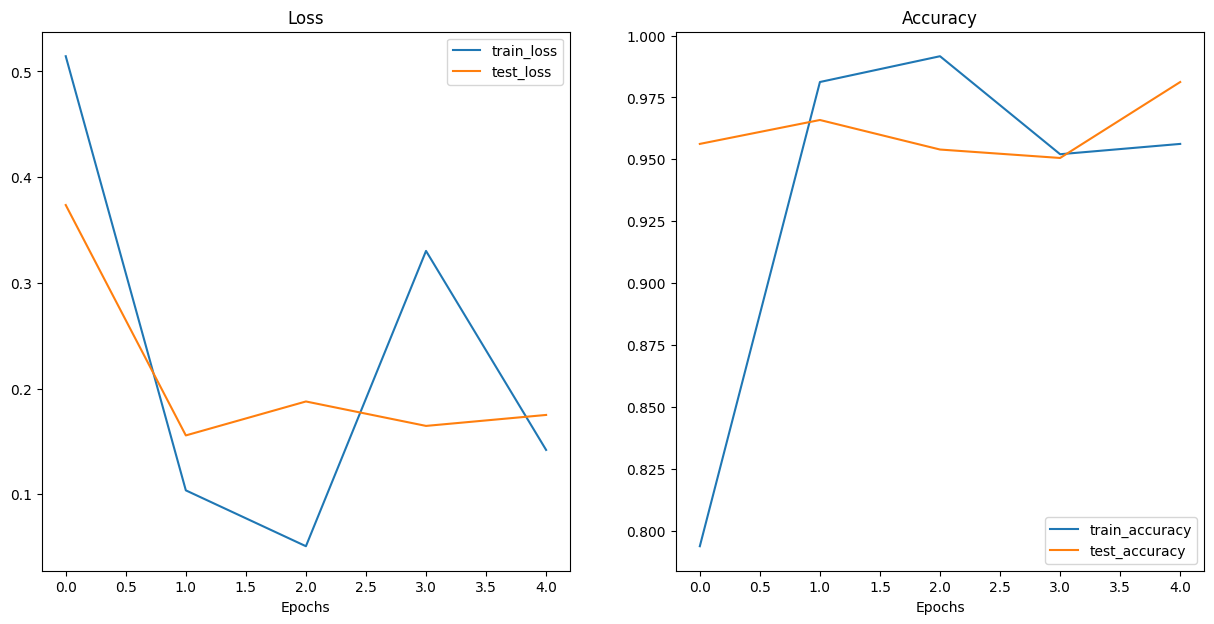

In [55]:
plot_loss_curves(best_results)

## 9. Deploy the Best Model with Gradio

In [57]:
# ============================================
# GRADIO DEPLOYMENT SETUP
# ============================================

import os
import shutil
from pathlib import Path

import torch
import gradio as gr
from PIL import Image
from torchvision import transforms

# Set device for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[SETUP] Using device: {device}")

[SETUP] Using device: cuda


In [58]:
# ============================================
# CREATE DEMO FOLDER STRUCTURE
# ============================================

# Define paths for demo files
foodvision_mini_demo_path = Path("demos/foodvision_mini")
examples_dir = foodvision_mini_demo_path / "examples"

# Clean slate: remove old demo folder if it exists
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    print("[SETUP] Removed old demo folder")

# Create fresh directories
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
examples_dir.mkdir(parents=True, exist_ok=True)
print(f"[SETUP] Created demo directory: {foodvision_mini_demo_path}")
print(f"[SETUP] Created examples directory: {examples_dir}")

[SETUP] Removed old demo folder
[SETUP] Created demo directory: demos/foodvision_mini
[SETUP] Created examples directory: demos/foodvision_mini/examples


In [60]:
# ============================================
# SELECT RANDOM EXAMPLE IMAGES
# ============================================

# Get all test images per class
pizza_images = list(Path("data/pizza_steak_sushi_20_percent/test/pizza").glob("*.jpg"))
steak_images = list(Path("data/pizza_steak_sushi_20_percent/test/steak").glob("*.jpg"))
sushi_images = list(Path("data/pizza_steak_sushi_20_percent/test/sushi").glob("*.jpg"))

# Randomly select one image from each class
foodvision_mini_examples = [
    random.choice(sushi_images),
    random.choice(steak_images),
    random.choice(pizza_images),
]

print(f"[EXAMPLES] Selected random images:")
for img in foodvision_mini_examples:
    print(f"  - {img.parent.name}/{img.name}")

[EXAMPLES] Selected random images:
  - sushi/1346344.jpg
  - steak/670345.jpg
  - pizza/148765.jpg


In [63]:
# ============================================
# LOAD TRAINED MODEL
# ============================================

# Load the saved checkpoint file (contains weights + metadata)
# map_location=device ensures it loads to correct device (CPU/GPU)
checkpoint = torch.load("models/best_model.pth", map_location=device)

# Extract metadata from checkpoint dictionary
# Remember: We saved this as a dict with keys like 'model_state_dict', 'model_name', etc.
model_name = checkpoint["model_name"]        # e.g., "resnet50"
class_names = checkpoint["class_names"]      # e.g., ['pizza', 'steak', 'sushi']
test_accuracy = checkpoint["test_acc"]       # e.g., 0.9812

print(f"[MODEL] Loading {model_name}...")
print(f"[MODEL] Classes: {class_names}")
print(f"[MODEL] Test accuracy: {test_accuracy:.2%}")

# Step 1: Recreate the empty model architecture
# create_model() builds ResNet50/EfficientNet with random weights
# We need the architecture to match before loading trained weights
model, inference_transform = create_model(model_name, num_classes=len(class_names))

# Step 2: Load the TRAINED weights into the empty architecture
# checkpoint["model_state_dict"] contains all the learned parameters
# This replaces random weights with your trained weights
model.load_state_dict(checkpoint["model_state_dict"])

# Step 3: Move model to GPU/CPU
model = model.to(device)

# Step 4: Set to evaluation mode
# This disables dropout (keeps all neurons) and freezes batch norm stats
# Critical for consistent predictions during inference
model.eval()

print(f"[MODEL] ✓ Model loaded and ready for inference")

[MODEL] Loading resnet50...
[MODEL] Classes: ['pizza', 'steak', 'sushi']
[MODEL] Test accuracy: 98.12%
[MODEL] ✓ Model loaded and ready for inference


In [64]:
# ============================================
# PREDICTION FUNCTION FOR GRADIO
# ============================================

def predict(image):
    """
    Takes an image and returns class probabilities.

    Args:
        image: PIL Image or numpy array from Gradio

    Returns:
        Dictionary mapping class names to probabilities (0-1)
    """
    # Ensure image is PIL format
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    # Preprocess: PIL → Tensor [1, 3, 224, 224]
    img_tensor = inference_transform(image).unsqueeze(0).to(device)

    # Run inference (no gradient tracking needed)
    model.eval()
    with torch.inference_mode():
        outputs = model(img_tensor)  # Raw logits [1, 3]
        probs = torch.softmax(outputs, dim=1)  # Convert to probabilities

    # Format output as {class_name: probability}
    return {
        class_names[i]: float(probs[0][i])
        for i in range(len(class_names))
    }

print("[PREDICT] Prediction function defined")

[PREDICT] Prediction function defined


In [67]:
# ============================================
# CREATE GRADIO WEB INTERFACE
# ============================================

print("[GRADIO] Building interface...")

# created model by best name, loaded training weights, uswed in predict function
demo = gr.Interface(
    fn=predict,                              # Prediction function
    inputs=gr.Image(type="pil"),             # Accept image uploads
    outputs=gr.Label(num_top_classes=3, label="Predictions"),  # Show top 3 predictions

    # UI customization
    title="🍕🥩🍣 Food Classifier",
    description=(
        "Upload an image of **pizza**, **steak**, or **sushi** and the model will classify it!\n\n"
        f"**Model:** {model_name} | **Accuracy:** {test_accuracy:.2%}"
    ),
    theme="soft",                            # Clean visual theme

    # Example images (clickable in UI)
    examples=foodvision_mini_examples,
    examples_per_page=3,
    cache_examples=False,                    # Fresh predictions each time
    allow_flagging="never",                  # Disable user feedback collection
)

print("[GRADIO] ✓ Interface built successfully")

[GRADIO] Building interface...
[GRADIO] ✓ Interface built successfully


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


In [68]:
# ============================================
# LAUNCH GRADIO APP
# ============================================

print("\n" + "="*60)
print("🚀 LAUNCHING GRADIO APP")
print("="*60)
print("- Local URL: Will appear below")
print("- Public URL: share=True creates temporary public link")
print("- Press Ctrl+C to stop the server")
print("="*60 + "\n")

demo.launch(share=True)  # share=True creates public URL for 72 hours


🚀 LAUNCHING GRADIO APP
- Local URL: Will appear below
- Public URL: share=True creates temporary public link
- Press Ctrl+C to stop the server

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://679f5bd281f045e37c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
